In [1]:
import os
import argparse
from collections import OrderedDict as OD

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import colors

from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error


parser = argparse.ArgumentParser()
parseGroup1 = parser.add_mutually_exclusive_group(required=True)
parseGroup1.add_argument('--ChunkyDonut',    action='store_true', default=True)
parseGroup1.add_argument('--PhiRing',        action='store_true', default=False)
parseGroup2 = parser.add_mutually_exclusive_group(required=True)
parseGroup2.add_argument('--l1MatchOffline', action='store_true', default=False)
parseGroup2.add_argument('--l1MatchGen',     action='store_true', default=True)


#args = parser.parse_args()
args = parser.parse_args("--ChunkyDonut --l1MatchGen".split()) # to run in jupyter-notebook 
l1Jet_ChunkyDonut = args.ChunkyDonut
l1Jet_PhiRing     = args.PhiRing
l1MatchOffline    = args.l1MatchOffline
l1MatchGen        = args.l1MatchGen


sIpFileName     = "../data/L1T_Jet_MLInputs_Run3_QCD_Pt15to7000_PFA1p_CMSSW12_6_0_pre1_nVtxAll_20220925.csv"
sOpFileName_SFs = "../data/L1T_Jet_SFs_Run3_QCD_Pt15to7000_PFA1p_CMSSW12_6_0_pre1_nVtxAll_20220925.csv"
sOutDir         = "./plots"

iEtaBins = [i for i in range(1, 42) if i!=29]
sL1JetEt_PUS_ChunkyDonut = 'L1JetEt_PUS_ChunkyDonut'
sL1JetEt_PUS_PhiRing     = 'L1JetEt_PUS_PhiRing'
sOfflineJetEt            = 'PFJetEtCorr'
sGenJetEt                = 'GenJetEt'
sL1JetTowerIEtaAbs       = 'L1JetTowerIEtaAbs'
L1JetPtThrsh             = 10.0 # GeV
L1JetPtMax               = 255.0 # GeV

sL1JetEt  = sL1JetEt_PUS_ChunkyDonut if l1Jet_ChunkyDonut else sL1JetEt_PUS_PhiRing
sRefJetEt = sOfflineJetEt if l1MatchOffline else sGenJetEt 


data_all = pd.read_csv(sIpFileName)
print("Input file: %s" % (sIpFileName))
print("iEtaBins ({}): {}".format(len(iEtaBins), iEtaBins))
print("sRefJetEt: {}, \t sL1Jet: {}, \t L1JetPtThrsh: {}".format(sRefJetEt, sL1JetEt, L1JetPtThrsh))

Input file: ../data/L1T_Jet_MLInputs_Run3_QCD_Pt15to7000_PFA1p_CMSSW12_6_0_pre1_nVtxAll_20220925.csv
iEtaBins (40): [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41]
sRefJetEt: GenJetEt, 	 sL1Jet: L1JetEt_PUS_ChunkyDonut, 	 L1JetPtThrsh: 10.0


In [2]:
print("data_all.columns: {}, \ndata_all.shape: {}".format(data_all.columns, data_all.shape))

data_all.columns: Index(['runNumber', 'lumiSectionNumber', 'eventNumber', 'nVertexReco',
       'GenJetEt', 'nVertexGen', 'nMeanPUGen', 'L1JetType', 'L1JetDefault_Et',
       'L1JetTowerIEtaAbs', 'L1JetDefault_RawEt',
       'L1JetDefault_PUEt_ChunkyDonut', 'L1Jet9x9_RawEt',
       'L1Jet9x9_EtSum7PUTowers', 'L1Jet9x9_PUEt_ChunkyDonut'],
      dtype='object'), 
data_all.shape: (18218932, 15)


In [3]:
data_all[sL1JetEt_PUS_ChunkyDonut] = data_all['L1Jet9x9_RawEt'] - data_all['L1Jet9x9_PUEt_ChunkyDonut']

data_all[sL1JetEt_PUS_PhiRing]     = data_all['L1Jet9x9_RawEt'] - (data_all['L1Jet9x9_EtSum7PUTowers'] / 7.0 )

sL1JetEt_forML              = 'log_%s' % (sL1JetEt)
sRefJetEt_forML             = 'log_%s' % (sRefJetEt)
train_vars = [sL1JetTowerIEtaAbs, sL1JetEt_forML]
target_var = sRefJetEt_forML
print("\nsL1JetEt_forML: {}, sRefJetEt_forML: {}".format(sL1JetEt_forML, sRefJetEt_forML))
print("train_vars: {}, \ntarget_var: {}\n".format(train_vars, target_var))

def transform_JetEt_forML(series):
    series_new = np.log(series)
    return series_new;

def transform_back_JetEt_fromML(series):
    series_new = np.exp(series)
    return series_new;

def prepareDataframeForSFs(iEtaBinRange):
    dict_iEta_Et = OD([ (sL1JetTowerIEtaAbs, []), (sL1JetEt, []) ])
    for iEta in iEtaBinRange:
        list_pt      = np.arange(L1JetPtThrsh+1.0, L1JetPtMax+1.0)
        list_ietabin = [iEta] * len(list_pt)
        dict_iEta_Et[sL1JetTowerIEtaAbs].extend(list_ietabin) 
        dict_iEta_Et[sL1JetEt].extend(list_pt) 
          
    data_SFs = pd.DataFrame(dict_iEta_Et)
    data_SFs[sL1JetEt_forML]    = transform_JetEt_forML(data_SFs[sL1JetEt])
    return data_SFs

data_all[sL1JetEt_forML]    = transform_JetEt_forML(data_all[sL1JetEt])
data_all[sRefJetEt_forML]   = transform_JetEt_forML(data_all[sRefJetEt])

print("data_all.describe(): \n{}".format(data_all.describe()))
#print("\n\ndata_SFs.describe(): \n{}".format(data_SFs.describe()))
#print("\n\ndata_SFs.describe(): \n{}".format(data_SFs.to_string()))


sL1JetEt_forML: log_L1JetEt_PUS_ChunkyDonut, sRefJetEt_forML: log_GenJetEt
train_vars: ['L1JetTowerIEtaAbs', 'log_L1JetEt_PUS_ChunkyDonut'], 
target_var: log_GenJetEt

data_all.describe(): 
        runNumber  lumiSectionNumber   eventNumber   nVertexReco  \
count  18218932.0       1.821893e+07  1.821893e+07  1.821893e+07   
mean          1.0       1.444852e+04  4.912329e+06  4.917846e+01   
std           0.0       8.523267e+03  2.897911e+06  9.442895e+00   
min           1.0       2.000000e+00  3.410000e+02  0.000000e+00   
25%           1.0       7.160000e+03  2.434180e+06  4.300000e+01   
50%           1.0       1.414000e+04  4.807572e+06  5.000000e+01   
75%           1.0       2.187400e+04  7.436836e+06  5.600000e+01   
max           1.0       2.941200e+04  1.000000e+07  9.200000e+01   

           GenJetEt    nVertexGen    nMeanPUGen  L1JetDefault_Et  \
count  1.821893e+07  1.821893e+07  1.821893e+07     1.821893e+07   
mean   1.386184e+02  4.975521e+01  4.917846e+01     1.378540

In [4]:
## data cleaning--------

# Drop entries with L1JetEt < L1JetPtThrsh
data_all_L1EtBelowThrsh = data_all[ data_all[sL1JetEt] < L1JetPtThrsh ]
print("data_all[ data_all['{}'] < {} ]: \n{}".format(sL1JetEt, L1JetPtThrsh, data_all_L1EtBelowThrsh))
data_all.drop(index=data_all_L1EtBelowThrsh.index, inplace=True)

print("\nDoes any of the columns have NaN entries: \ndata_all.isna().sum(): \n{}".format(data_all.isna().sum()))
print("\nAfter cleaning, data_all.describe(): \n{}".format(data_all.describe()))

data_all[ data_all['L1JetEt_PUS_ChunkyDonut'] < 10.0 ]: 
          runNumber  lumiSectionNumber  eventNumber  nVertexReco   GenJetEt  \
35                1                  9         2734           55   8.494193   
38                1                  9         2739           54  14.118650   
78                1                  9         2756           51  44.941246   
84                1                  9         2758           49   7.298351   
102               1                  9         2771           42  30.310617   
...             ...                ...          ...          ...        ...   
18218795          1              26513      9014356           24  50.380184   
18218811          1              26513      9014364           31   4.765135   
18218822          1              26513      9014374           50   5.093503   
18218881          1              26513      9014399           64  10.236115   
18218887          1              26513      9014403           35  14.84641

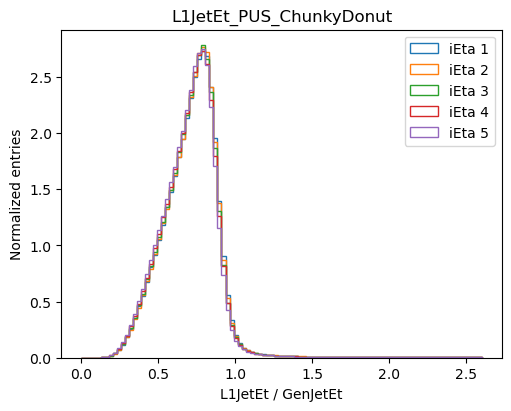

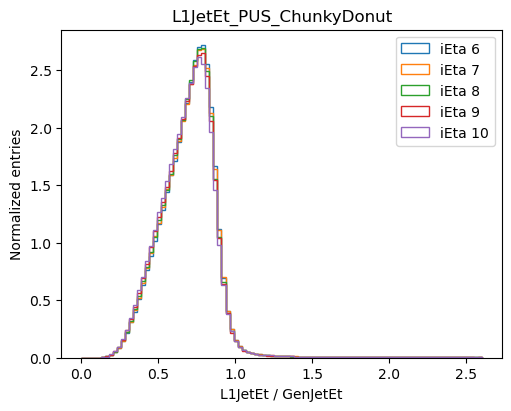

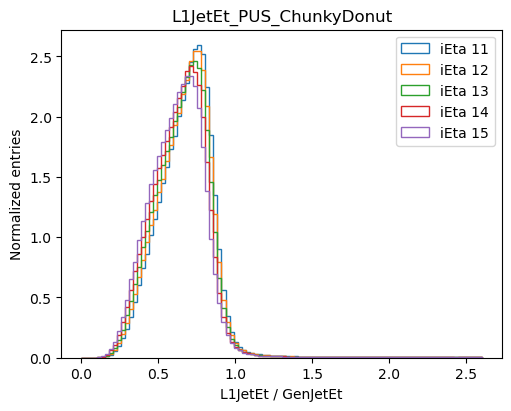

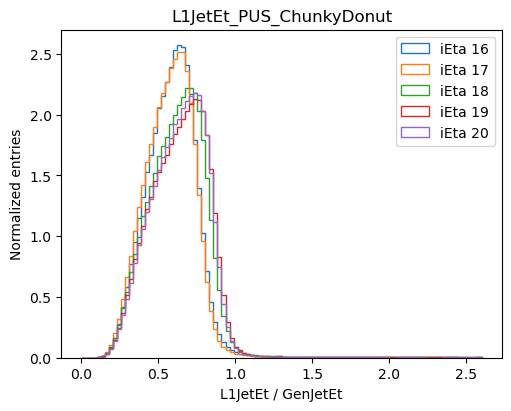

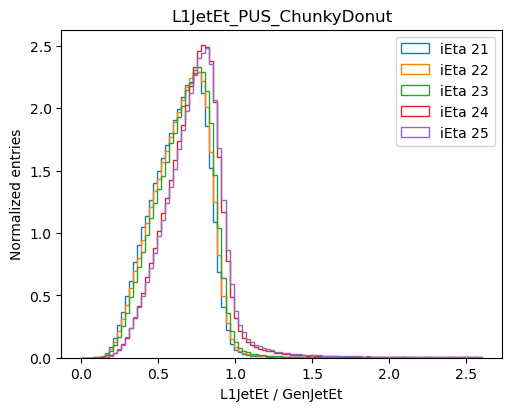

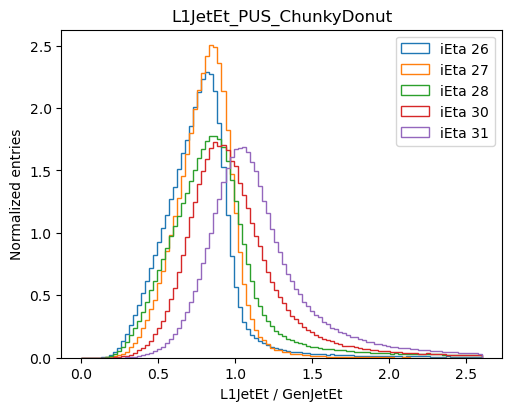

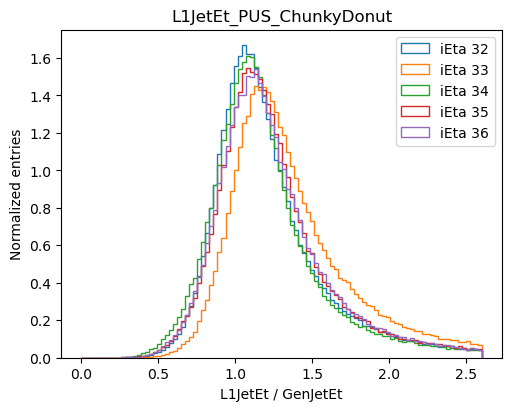

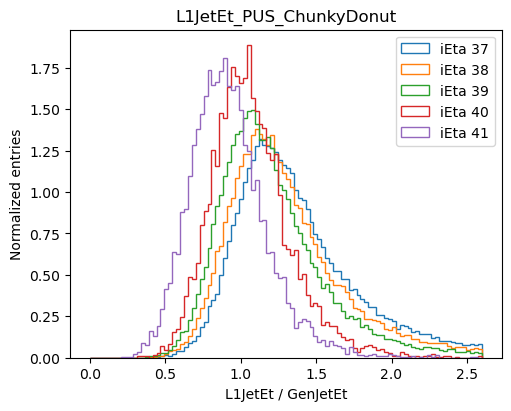

In [5]:
## make resolution plots before JEC

if not os.path.exists(sOutDir): 
    os.makedirs(sOutDir)

#print("".format())
for iEtaBinRange in np.array_split(iEtaBins, 8):
    fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
        
    
    for iEtaBin in iEtaBinRange:
        data_all_iEtaBin = data_all[data_all[sL1JetTowerIEtaAbs] == iEtaBin]
        axs.hist(
            (data_all_iEtaBin[sL1JetEt]/data_all_iEtaBin[sRefJetEt]), 
            bins=100, range=(0, 2.6),
            label='iEta %d' % (iEtaBin),
            histtype='step',#, linewidth=2
            density=True
        )
    axs.set_xlabel('L1JetEt / %s' % (sRefJetEt))
    axs.set_ylabel('Normalized entries')
    axs.set_title('%s' % (sL1JetEt))
    axs.legend()
        
    fig.savefig('%s/beforeJEC_%s_ieta_%d_to_%d.png' % (sOutDir, sL1JetEt, iEtaBinRange[0], iEtaBinRange[-1]))
        


nEntriesPerIEtaBin: [687823, 665817, 661202, 650717, 651409, 652677, 628980, 615541, 613590, 615331, 583167, 562550, 547802, 540535, 516934, 459912, 465561, 391051, 447397, 457940, 378603, 430785, 450249, 518915, 577617, 699780, 308696, 774077, 327766, 345148, 255168, 246822, 215032, 164539, 130655, 92590, 66487, 45565, 8942, 7382]
nEntriesPerIEtaBin_1: {1: 687823, 2: 665817, 3: 661202, 4: 650717, 5: 651409, 6: 652677, 7: 628980, 8: 615541, 9: 613590, 10: 615331, 11: 583167, 12: 562550, 13: 547802, 14: 540535, 15: 516934, 16: 459912, 17: 465561, 18: 391051, 19: 447397, 20: 457940, 21: 378603, 22: 430785, 23: 450249, 24: 518915, 25: 577617, 26: 699780, 27: 308696, 28: 774077, 30: 327766, 31: 345148, 32: 255168, 33: 246822, 34: 215032, 35: 164539, 36: 130655, 37: 92590, 38: 66487, 39: 45565, 40: 8942, 41: 7382}


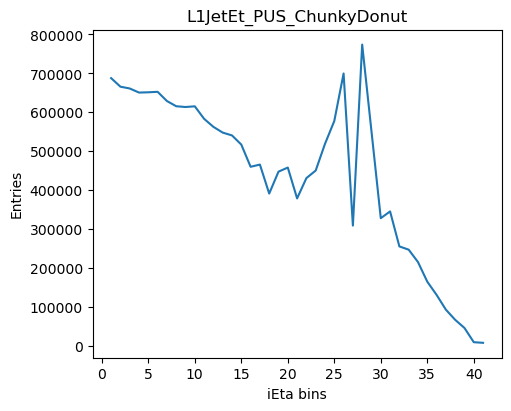

In [6]:
nEntriesPerIEtaBin = [len(data_all[data_all[sL1JetTowerIEtaAbs] == iEtaBin].index) for iEtaBin in iEtaBins]   
nEntriesPerIEtaBin_1 = { iEtaBin: len(data_all[data_all[sL1JetTowerIEtaAbs] == iEtaBin].index) for iEtaBin in iEtaBins}   
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(5,4), layout='constrained')
axs.plot(iEtaBins, nEntriesPerIEtaBin)
axs.set_xlabel('iEta bins')
axs.set_ylabel('Entries')
axs.set_title('%s' % (sL1JetEt))
#axs.legend()
fig.savefig('%s/%s_nEntriesPerIEtaBin.png' % (sOutDir, sL1JetEt))
print("nEntriesPerIEtaBin: {}".format(nEntriesPerIEtaBin))
print("nEntriesPerIEtaBin_1: {}".format(nEntriesPerIEtaBin_1))

In [7]:
%%time

IEta_Cat = OD()
#IEta_Cat['HB'] = [ 1, 16]
#IEta_Cat['HE'] = [17, 28]
#IEta_Cat['HF'] = [30, 41]
IEta_Cat['HBEF'] = [ 1, 41]

varsOfInterest = train_vars
varsOfInterest.extend([target_var, sL1JetEt, sRefJetEt])
print("varsOfInterest: {}\n".format(varsOfInterest))

for iEta_category, iEtaBinRange in IEta_Cat.items():
    data_all_iEtaBins = data_all[
        (data_all[sL1JetTowerIEtaAbs] >= iEtaBinRange[0]) & 
        (data_all[sL1JetTowerIEtaAbs] <= iEtaBinRange[-1])
    ][varsOfInterest]
    print("\niEta_category {}, iEtaBinRange {}, data_all_iEtaBins.describe(): \n{}".format(iEta_category, iEtaBinRange, data_all_iEtaBins.describe()))
    
    X = data_all_iEtaBins[train_vars]
    y = data_all_iEtaBins[target_var]

    X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=0)
    
    # declare parameters
    params_i = {
        'n_estimators': 1000, 
        'learning_rate': 0.01, 
        'early_stopping_rounds': 5
    }
    xgb_rg = XGBRegressor(**params_i)
    xgb_rg.fit(X_train, y_train,
               eval_set=[(X_valid, y_valid)],
               verbose=False
             )
    print("\niEta_category {}, iEtaBinRange {}, params: {}, mean_squared_error: {}; {}".format(
        iEta_category, iEtaBinRange, 
        params_i,
        mean_squared_error(y_valid, xgb_rg.predict(X_valid)),
        mean_squared_error(y_valid, xgb_rg.predict(X_valid), squared=False)
    ))
    
    
    
    
print("Hello1")    

varsOfInterest: ['L1JetTowerIEtaAbs', 'log_L1JetEt_PUS_ChunkyDonut', 'log_GenJetEt', 'L1JetEt_PUS_ChunkyDonut', 'GenJetEt']


iEta_category HBEF, iEtaBinRange [1, 41], data_all_iEtaBins.describe(): 
       L1JetTowerIEtaAbs  log_L1JetEt_PUS_ChunkyDonut  log_GenJetEt  \
count       1.746075e+07                 1.746075e+07  1.746075e+07   
mean        1.582115e+01                 4.246308e+00  4.582349e+00   
std         9.965262e+00                 9.599394e-01  9.391240e-01   
min         1.000000e+00                 2.302585e+00  1.098616e+00   
25%         7.000000e+00                 3.496508e+00  3.950385e+00   
50%         1.500000e+01                 4.241327e+00  4.621309e+00   
75%         2.400000e+01                 5.010635e+00  5.289672e+00   
max         4.100000e+01                 6.738152e+00  7.632310e+00   

       L1JetEt_PUS_ChunkyDonut      GenJetEt  
count             1.746075e+07  1.746075e+07  
mean              1.079545e+02  1.438310e+02  
std               1.